In [1]:
import os
import torch
import timm
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.utils.data import random_split
from torchvision.datasets.folder import default_loader
from tqdm import tqdm


c:\Users\hoang\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============ Config =============
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = './dataset/dataset_raw/'

In [3]:
IMG_SIZE = 224

train_transform = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


c:\Users\hoang\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
# ============ Custom Dataset =============
from torch.utils.data import Dataset
import cv2

class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # path, label = self.dataset.samples[idx]
        # Đúng:
        path, label = self.dataset.dataset.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image']
        return image, label

In [5]:
from torch.utils.data import Subset
dataset = ImageFolder(DATA_DIR)
targets = [sample[1] for sample in dataset.samples]

from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_ds = AlbumentationsDataset(train_ds, train_transform)
val_ds = AlbumentationsDataset(val_ds, val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
# ============ Model Setup =============
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# ============ Training Loop =============
def train(model, train_loader, val_loader):
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = train_loss / len(train_loader)
        acc = 100. * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(acc)
        print(f"✅ Train Loss: {avg_loss:.4f} | Train Acc: {acc:.2f}%")

        validate(model, val_loader)
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    acc = 100. * correct / total
    val_losses.append(avg_loss)
    val_accuracies.append(acc)
    print(f"Val Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")


In [8]:
train(model, train_loader, val_loader)

Epoch 1/10: 100%|██████████| 71/71 [04:21<00:00,  3.69s/it]


✅ Train Loss: 1.6961 | Train Acc: 56.45%
Val Loss: 0.7417 | Val Acc: 78.19%


Epoch 2/10: 100%|██████████| 71/71 [04:24<00:00,  3.73s/it]


✅ Train Loss: 0.7138 | Train Acc: 77.65%
Val Loss: 0.4209 | Val Acc: 84.04%


Epoch 3/10: 100%|██████████| 71/71 [05:00<00:00,  4.24s/it]


✅ Train Loss: 0.4527 | Train Acc: 84.88%
Val Loss: 0.2769 | Val Acc: 89.36%


Epoch 4/10: 100%|██████████| 71/71 [05:02<00:00,  4.26s/it]


✅ Train Loss: 0.3266 | Train Acc: 88.69%
Val Loss: 0.1510 | Val Acc: 94.50%


Epoch 5/10: 100%|██████████| 71/71 [04:50<00:00,  4.09s/it]


✅ Train Loss: 0.2325 | Train Acc: 91.84%
Val Loss: 0.1319 | Val Acc: 95.57%


Epoch 6/10: 100%|██████████| 71/71 [04:51<00:00,  4.10s/it]


✅ Train Loss: 0.1787 | Train Acc: 93.66%
Val Loss: 0.1166 | Val Acc: 96.10%


Epoch 7/10: 100%|██████████| 71/71 [04:51<00:00,  4.10s/it]


✅ Train Loss: 0.1562 | Train Acc: 94.41%
Val Loss: 0.0785 | Val Acc: 97.87%


Epoch 8/10: 100%|██████████| 71/71 [04:53<00:00,  4.14s/it]


✅ Train Loss: 0.0968 | Train Acc: 96.54%
Val Loss: 0.0462 | Val Acc: 98.76%


Epoch 9/10: 100%|██████████| 71/71 [04:49<00:00,  4.07s/it]


✅ Train Loss: 0.0974 | Train Acc: 96.59%
Val Loss: 0.0300 | Val Acc: 98.94%


Epoch 10/10: 100%|██████████| 71/71 [04:51<00:00,  4.10s/it]


✅ Train Loss: 0.0679 | Train Acc: 97.65%
Val Loss: 0.0516 | Val Acc: 98.23%


In [9]:
# ============ Save Model ============
torch.save(model.state_dict(), "snake_classifie.pth")

✅ Accuracy: 98.23%
📊 Classification Report:
                 precision    recall  f1-score   support

    ran_ho_mang       1.00      0.99      0.99       501
   ran_rao_trau       0.95      0.94      0.94        63
ran_luc_duoi_do       0.00      0.00      0.00         0
       ran_nuoc       0.00      0.00      0.00         0
   ran_cap_nong       0.00      0.00      0.00         0

       accuracy                           0.98       564
      macro avg       0.39      0.38      0.39       564
   weighted avg       0.99      0.98      0.99       564



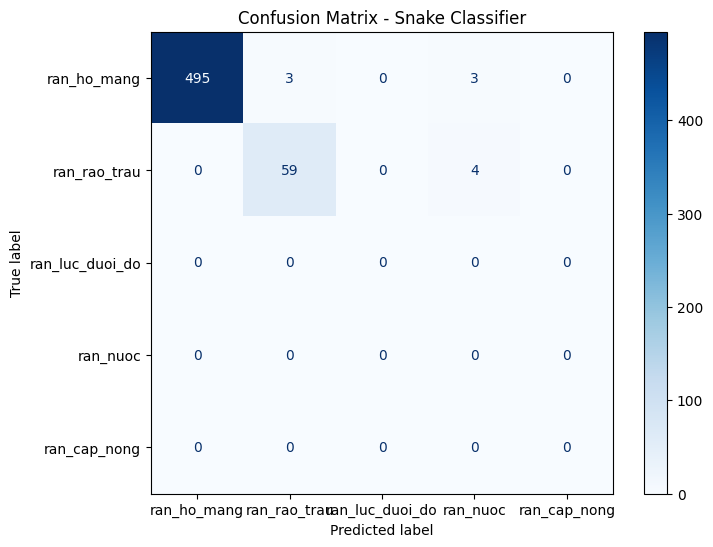

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        try:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        except Exception as e:
            print(f"⚠️ Bỏ qua batch {i} do lỗi: {e}")
            continue

# Tính accuracy
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc * 100:.2f}%")
CLASS_NAMES = ['ran_ho_mang', 'ran_rao_trau', 'ran_luc_duoi_do', 'ran_nuoc', 'ran_cap_nong']

# Báo cáo chi tiết từng lớp
labels = list(range(len(CLASS_NAMES)))
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, labels=labels, zero_division=0))

# Vẽ ma trận nhầm lẫn
labels = list(range(len(CLASS_NAMES)))
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix - Snake Classifier")
plt.grid(False)
plt.show()



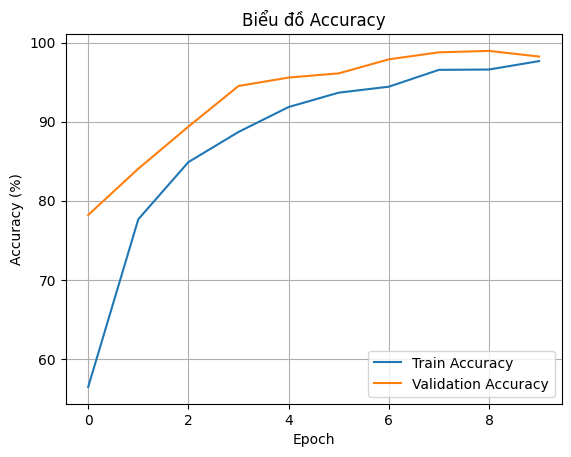

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Biểu đồ Accuracy")
plt.legend()
plt.grid(True)
plt.show()
